What companies do business in Iran? This is mostly meant as a tutorial for using datamule as well as testing where the user experience is bad. As such, the analysis might be a bit sloppy / not the best fact checked. Still better than The Economist!

Note: I like The Economist.

In [3]:
from datamule import PremiumDownloader, Downloader, Portfolio

downloader = PremiumDownloader() # or Downloader()

# Download all irannotice submissions
downloader.download_submissions(submission_type=['IRANNOTICE'],output_dir='../ingest/irannotice')


Cost: $0.040870000000 downloads + $0.000004088000 row reads = $0.040874088000
Balance: $8.296783176000


Processing files: 100%|██████████| 4087/4087 [00:18<00:00, 217.87it/s]


Processing completed in 18.76 seconds


In [175]:
import pandas as pd

# Load the portfolio
portfolio = Portfolio('../ingest/irannotice')
# Create list of submissions
submissions_data = []

for submission in portfolio:
    metadata = submission.metadata['submission']
    
    # Extract data based on format
    if 'FILING-DATE' in metadata:
        # Archive format (from daily archives) - note: I'll harmonize the field names soon. Sorry for the inconvenience.
        filing_date = metadata.get('FILING-DATE')
        filer_data = metadata.get('FILER', {})
        company_data = filer_data.get('COMPANY-DATA', {})
        cik = company_data.get('CIK')
        sic = company_data.get('ASSIGNED-SIC')
        name = company_data.get('CONFORMED-NAME')

        business_addr = filer_data.get('BUSINESS-ADDRESS', {})
        street1 = business_addr.get('STREET1')
        street2 = business_addr.get('STREET2')
        city = business_addr.get('CITY')
        state = business_addr.get('STATE')
        zip = business_addr.get('ZIP')
    else:
        # Header format (from scraped submissions)
        filing_date = metadata.get('FILED AS OF DATE')
        filer_data = metadata.get('FILER', {})
        company_data = filer_data.get('COMPANY DATA', {})
        cik = company_data.get('CENTRAL INDEX KEY')
        sic = company_data.get('STANDARD INDUSTRIAL CLASSIFICATION')
        name = company_data.get('CONFORMED NAME')

        business_addr = filer_data.get('BUSINESS ADDRESS', {})
        street1 = business_addr.get('STREET 1')
        city = business_addr.get('CITY') 
        state = business_addr.get('STATE')
        zip = business_addr.get('ZIP')
    
    submissions_data.append({
        'filing_date': filing_date,
        'cik': cik,
        'name': name,
        'sic': sic,
        'street1': street1,
        'city': city,
        'state': state,
        'zip': zip

    })

df = pd.DataFrame(submissions_data)


Loading 4087 submissions


Loading submissions: 100%|██████████| 4087/4087 [00:00<00:00, 4391.97it/s]


In [176]:
# Let's load the company metadata package, which includes sic descriptions
from datamule import load_package_dataset

company_metadata = pd.DataFrame(load_package_dataset('company_metadata'))

print(company_metadata.head())

          cik            name entityType   sic  \
0  0000320193      Apple Inc.  operating  3571   
1  0000789019  MICROSOFT CORP  operating  7372   
2  0001045810     NVIDIA CORP  operating  3674   
3  0001652044   Alphabet Inc.  operating  7370   
4  0001018724  AMAZON COM INC  operating  5961   

                                      sicDescription             ownerOrg  \
0                               Electronic Computers        06 Technology   
1                      Services-Prepackaged Software        06 Technology   
2                   Semiconductors & Related Devices     04 Manufacturing   
3  Services-Computer Programming, Data Processing...        06 Technology   
4                 Retail-Catalog & Mail-Order Houses  07 Trade & Services   

  insiderTransactionForOwnerExists insiderTransactionForIssuerExists  \
0                                0                                 1   
1                                1                                 1   
2                   

In [177]:
# Lets remove the duplicates and make a sic sic description mapping
company_metadata = company_metadata.drop_duplicates(subset=['sic'])
sic_description_mapping = company_metadata[['sic', 'sicDescription']]

print(sic_description_mapping.head())

    sic                                     sicDescription
0  3571                               Electronic Computers
1  7372                      Services-Prepackaged Software
2  3674                   Semiconductors & Related Devices
3  7370  Services-Computer Programming, Data Processing...
4  5961                 Retail-Catalog & Mail-Order Houses


In [178]:
# We then merge the sicDescription with sics code
df = df.merge(sic_description_mapping, on='sic', how='left')

# Save the data
df.to_csv('../data/irannotice_submissions.csv', index=False)

# Let's see the first few rows
print(df.head())

  filing_date         cik                        name   sic  \
0    20220504  0000002488  ADVANCED MICRO DEVICES INC  3674   
1    20230227  0000002488  ADVANCED MICRO DEVICES INC  3674   
2    20130301  0000003570         CHENIERE ENERGY INC  4924   
3    20130503  0000003570         CHENIERE ENERGY INC  4924   
4    20130510  0000003570         CHENIERE ENERGY INC  4924   

                street1         city state    zip  \
0  2485 AUGUSTINE DRIVE  SANTA CLARA    CA  95054   
1  2485 AUGUSTINE DRIVE  SANTA CLARA    CA  95054   
2         700 MILAM ST.      HOUSTON    TX  77002   
3         700 MILAM ST.      HOUSTON    TX  77002   
4         700 MILAM ST.      HOUSTON    TX  77002   

                     sicDescription  
0  Semiconductors & Related Devices  
1  Semiconductors & Related Devices  
2          Natural Gas Distribution  
3          Natural Gas Distribution  
4          Natural Gas Distribution  


Lets explore the data now

C:\Users\jgfri\AppData\Local\Temp\ipykernel_14024\3950170211.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


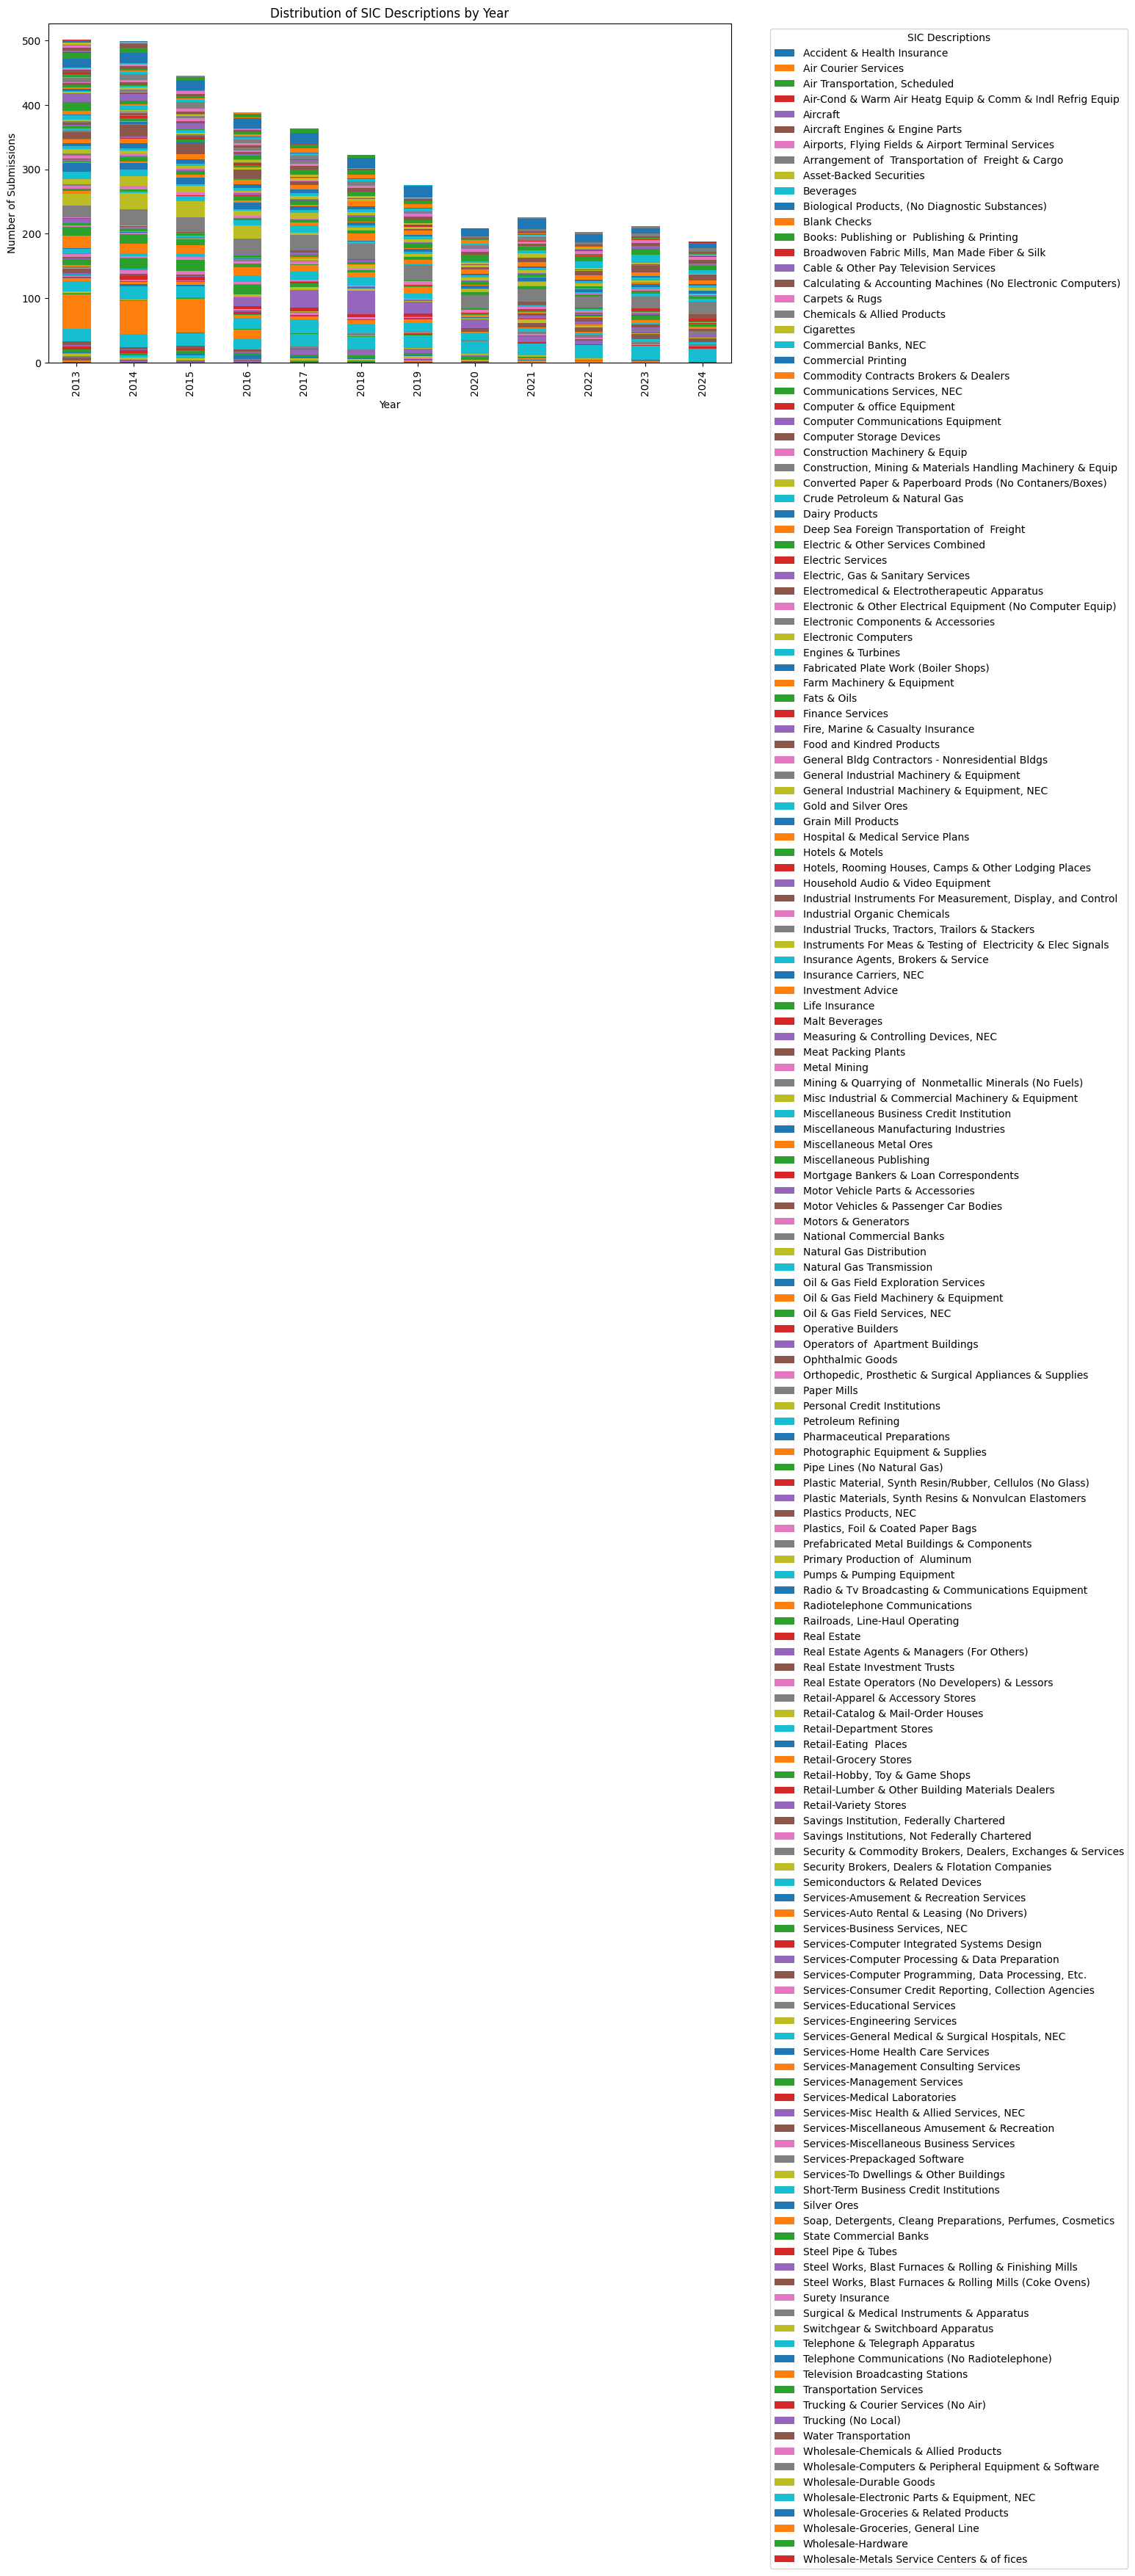

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('../data/irannotice_submissions.csv')

# Convert filing_date to datetime and extract year
df['year'] = pd.to_datetime(df['filing_date'], format='%Y%m%d').dt.year

# Create a pivot table to count occurrences of each SIC description per year
pivot_data = df.pivot_table(
    index='year',
    columns='sicDescription',
    aggfunc='size',
    fill_value=0
)

# Create a stacked bar chart
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

# Customize the chart
plt.title('Distribution of SIC Descriptions by Year')
plt.xlabel('Year')
plt.ylabel('Number of Submissions')
plt.legend(title='SIC Descriptions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

Wow that is ugly. Let's see if we can group sic categories. We'll use generative AI for this, because I don't want to do it by hand.

In [181]:
# print all sic descriptions
print(df['sicDescription'].unique())

['Semiconductors & Related Devices' 'Natural Gas Distribution'
 'Finance Services' 'Short-Term Business Credit Institutions'
 'Misc Industrial & Commercial Machinery & Equipment' 'Fats & Oils'
 'Services-Computer Processing & Data Preparation' 'Aircraft'
 'Plastic Materials, Synth Resins & Nonvulcan Elastomers'
 'Railroads, Line-Haul Operating' 'Construction Machinery & Equip'
 'Telephone Communications (No Radiotelephone)'
 'National Commercial Banks'
 'Construction, Mining & Materials Handling Machinery & Equip'
 'Pumps & Pumping Equipment' 'Petroleum Refining'
 'Electronic & Other Electrical Equipment (No Computer Equip)'
 'Personal Credit Institutions'
 'Services-Auto Rental & Leasing (No Drivers)'
 'Computer & office Equipment' 'Pharmaceutical Preparations'
 'Crude Petroleum & Natural Gas'
 'Services-Consumer Credit Reporting, Collection Agencies'
 'Surgical & Medical Instruments & Apparatus' 'Commercial Banks, NEC'
 'Calculating & Accounting Machines (No Electronic Computers)'
 '

I now pass this into Claude using a basic prompt:

these are all sic descriptions. can you organize them into groups? only organize them into groups if they are similar industries. otherwise they can stay on their own. 

after response:
neat: output the groups and stand alones as a python dict?

In [67]:
sic_groups = {
    "Technology & Electronics": [
        "Electronic Computers",
        "Services-Computer Programming, Data Processing, Etc.",
        "Services-Prepackaged Software",
        "Computer Communications Equipment",
        "Computer Storage Devices",
        "Electronic Components & Accessories",
        "Semiconductors & Related Devices",
        "Computer Integrated Systems Design"
    ],
    
    "Financial Services": [
        "National Commercial Banks",
        "Commercial Banks, NEC",
        "State Commercial Banks",
        "Personal Credit Institutions",
        "Investment Advice",
        "Security Brokers, Dealers & Flotation Companies",
        "Mortgage Bankers & Loan Correspondents",
        "Miscellaneous Business Credit Institution"
    ],
    
    "Oil, Gas & Energy": [
        "Natural Gas Distribution",
        "Crude Petroleum & Natural Gas",
        "Oil & Gas Field Services, NEC",
        "Oil & Gas Field Machinery & Equipment",
        "Natural Gas Transmission",
        "Petroleum Refining",
        "Electric Services",
        "Electric & Other Services Combined"
    ],
    
    "Industrial Equipment & Manufacturing": [
        "Industrial Trucks, Tractors, Trailers & Stackers",
        "Construction Machinery & Equipment",
        "Pumps & Pumping Equipment",
        "Industrial Instruments For Measurement, Display, and Control",
        "Farm Machinery & Equipment",
        "General Industrial Machinery & Equipment",
        "Motors & Generators",
        "Engines & Turbines"
    ],
    
    "Insurance": [
        "Life Insurance",
        "Fire, Marine & Casualty Insurance",
        "Accident & Health Insurance",
        "Insurance Carriers, NEC",
        "Surety Insurance",
        "Insurance Agents, Brokers & Service"
    ],
    
    "Real Estate": [
        "Real Estate Investment Trusts",
        "Real Estate Agents & Managers",
        "Operators of Apartment Buildings",
        "Real Estate Operators (No Developers) & Lessors",
        "Operative Builders"
    ],
    
    "Transportation & Logistics": [
        "Air Transportation, Scheduled",
        "Railroads, Line-Haul Operating",
        "Trucking & Courier Services",
        "Air Courier Services",
        "Deep Sea Foreign Transportation of Freight",
        "Airports, Flying Fields & Airport Terminal Services",
        "Transportation Services"
    ],
    
    "Healthcare": [
        "Hospital & Medical Service Plans",
        "Services-Medical Laboratories",
        "Services-Home Health Care Services",
        "Services-General Medical & Surgical Hospitals",
        "Pharmaceutical Preparations",
        "Surgical & Medical Instruments & Apparatus",
        "Orthopedic, Prosthetic & Surgical Appliances & Supplies"
    ],
    
    "Retail & Wholesale": [
        "Retail-Catalog & Mail-Order Houses",
        "Retail-Variety Stores",
        "Retail-Department Stores",
        "Retail-Grocery Stores",
        "Wholesale-Durable Goods",
        "Wholesale-Hardware",
        "Wholesale-Groceries & Related Products"
    ],
    
    "Chemical & Materials": [
        "Plastic Materials, Synth Resins & Nonvulcan Elastomers",
        "Industrial Organic Chemicals",
        "Chemicals & Allied Products",
        "Plastics Products, NEC",
        "Steel Works, Blast Furnaces & Rolling Mills",
        "Primary Production of Aluminum"
    ],
    
    "Other": [
        "Books: Publishing or Publishing & Printing",
        "Hotels & Motels",
        "Cable & Other Pay Television Services",
        "Television Broadcasting Stations",
        "Cigarettes",
        "Commercial Printing",
        "Dairy Products",
        "Metal Mining",
        "Paper Mills",
        "Beverages",
        "Malt Beverages",
        "Grain Mill Products",
        "Meat Packing Plants"
    ]
}

Now we work on the pretty version of our graph

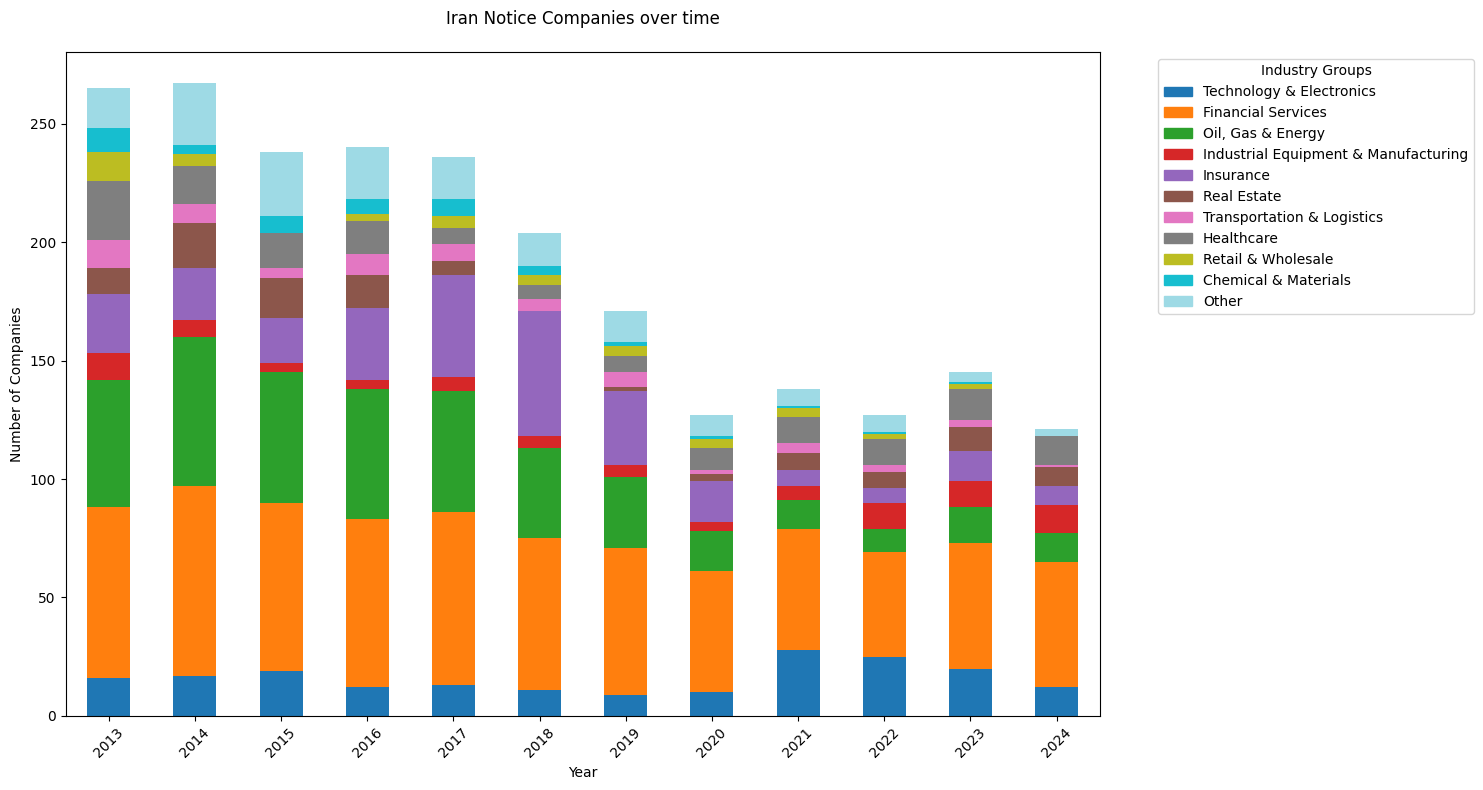

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('../data/irannotice_submissions.csv')

# Convert filing_date to datetime and extract year
df['year'] = pd.to_datetime(df['filing_date'], format='%Y%m%d').dt.year

# Create a reverse mapping from individual SIC descriptions to their groups
sic_to_group = {}
for group, descriptions in sic_groups.items():
    for desc in descriptions:
        sic_to_group[desc] = group

# Map SIC descriptions to their groups
df['industry_group'] = df['sicDescription'].map(lambda x: sic_to_group.get(x, x))

# Group and pivot
grouped_data = df.groupby(['year', 'industry_group']).size().reset_index(name='count')
pivot_data = grouped_data.pivot(index='year', columns='industry_group', values='count').fillna(0)

# Order columns according to sic_groups order
ordered_columns = list(sic_groups.keys())
pivot_data = pivot_data[ordered_columns]

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot with consistent colors
colors = plt.cm.tab20(np.linspace(0, 1, len(ordered_columns)))
pivot_data.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(ordered_columns))]
ax.legend(handles, ordered_columns, 
         title='Industry Groups',
         bbox_to_anchor=(1.05, 1),
         loc='upper left')

plt.title('Iran Notice Companies over time', pad=20)
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

This is interesting:
1. Tech went up!
2. Financial Services trends down
3. Oil collapses
4. Industries goes down at first, but rises back up
5. Insurance disclosures go way up during Trump's first term 
6. Real Estate disappears during Trump, back under Biden
7. Transportation & Logistics almost disappears
8. Manufacturing goes down at first, but rises back up
9. Healthcare declines, but settles at a stable rate. Probably not a Trump effect since it start under Obama, and stabilizes before Trump leaves office.
10. Chemical & Materials goes to zero. Possible Trump effect.


Note: This graph would be prettier if it was stacked from small to big. I don't know how to do that, but I've messed around enough with plotting in R that I do not want to attempt it. If you know how to do this, I would be happy to learn.

Now, I'm curious about whether companies file consistently, e.g. are they constantly doing business in Iran, or maybe they file every few years....

Let's evaluate this using 3 cases:

1. filed this year and the year before
2. new filer
3. filed this year and previously, but not the year before

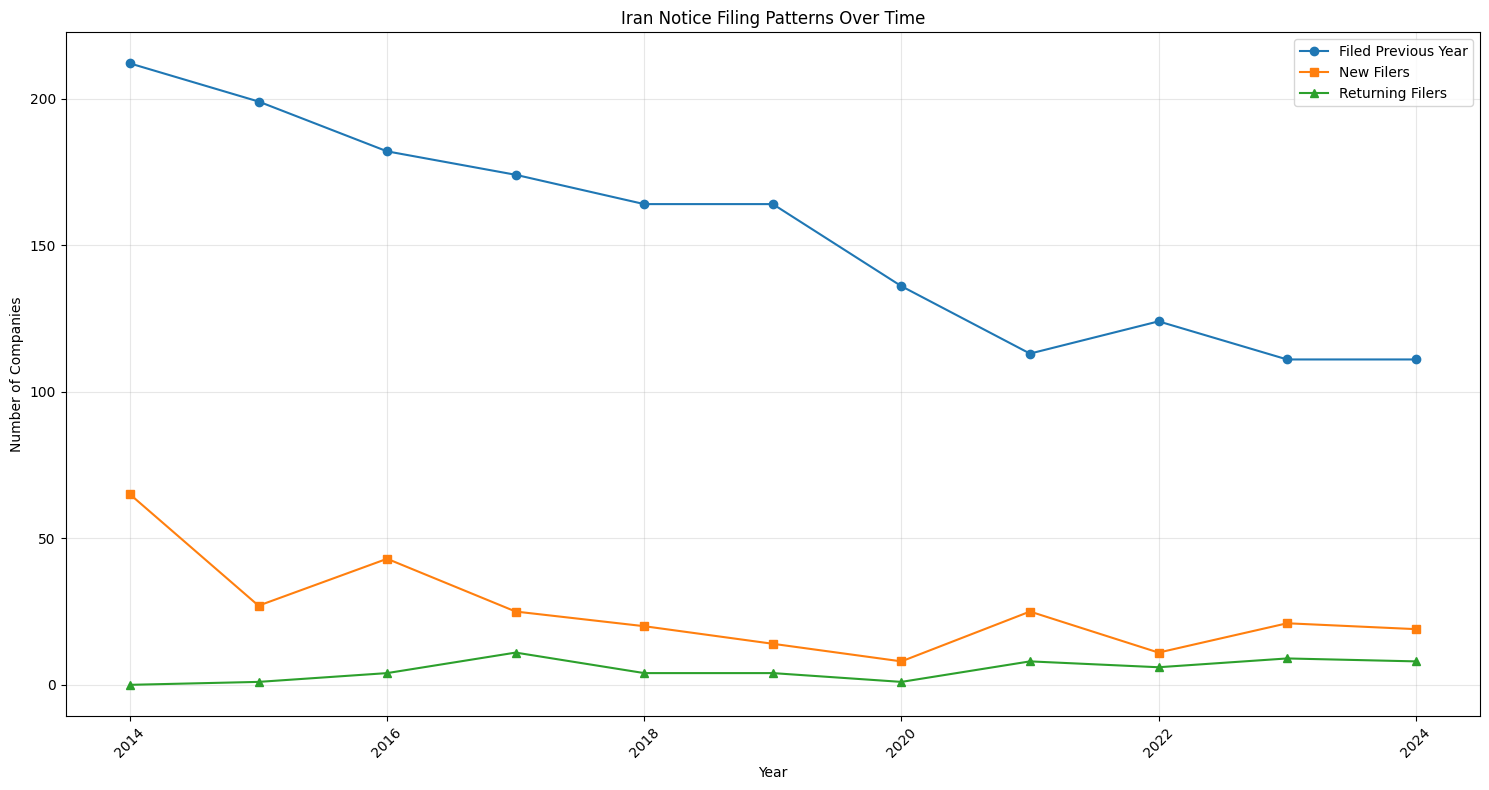


Summary of filing patterns:

Average annual counts:
consecutive    153.6
new             25.3
returning        5.1
dtype: float64

Total unique companies: 558


In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('../data/irannotice_submissions.csv')

# Convert filing_date to datetime and extract year
df['year'] = pd.to_datetime(df['filing_date'], format='%Y%m%d').dt.year

# Sort by CIK and year
df_sorted = df.sort_values(['cik', 'year'])

# Get unique years, excluding the first year for analysis
years = sorted(df['year'].unique())
analysis_years = years[1:]  # Start from second year

# Initialize results dictionary, starting from second year
results = {year: {'consecutive': 0, 'new': 0, 'returning': 0} for year in analysis_years}

# For each year, analyze the filing patterns
for year in analysis_years:
    # Get all CIKs that filed this year
    current_filers = set(df[df['year'] == year]['cik'])
    
    # Get all CIKs that filed in previous years
    previous_filers = set(df[df['year'] < year]['cik'])
    
    # Get CIKs that filed last year
    last_year_filers = set(df[df['year'] == (year-1)]['cik'])
    
    # Calculate each category
    consecutive = len(current_filers & last_year_filers)
    new = len(current_filers - previous_filers)
    returning = len(current_filers - last_year_filers - (current_filers - previous_filers))
    
    # Store results
    results[year]['consecutive'] = consecutive
    results[year]['new'] = new
    results[year]['returning'] = returning

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results).T

# Create the line plot
plt.figure(figsize=(15, 8))

plt.plot(results_df.index, results_df['consecutive'], marker='o', label='Filed Previous Year')
plt.plot(results_df.index, results_df['new'], marker='s', label='New Filers')
plt.plot(results_df.index, results_df['returning'], marker='^', label='Returning Filers')

plt.title('Iran Notice Filing Patterns Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.legend()
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary of filing patterns:")
print("\nAverage annual counts:")
print(results_df.mean().round(1))
print("\nTotal unique companies:", len(df['cik'].unique()))

Huh, those trends are remarkably stable.
1. Companies are clearly exiting Iran (or no longer file IRAN NOTICE)
2. New Filers and returning are constant over time
3. No clear Trump/Biden effect observable

I'm curious what companies file non-consecutively, and what their patterns are like

In [184]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('../data/irannotice_submissions.csv')

# Convert filing_date to datetime and extract year
df['year'] = pd.to_datetime(df['filing_date'], format='%Y%m%d').dt.year

# Create pivot table showing all filing patterns
filing_matrix = pd.pivot_table(
    df,
    values='filing_date',
    index='cik',
    columns='year',
    aggfunc='count'
).notnull().astype(int)

# Find companies that have gaps (filed, then didn't file, then filed again)
has_gap = []
for idx in filing_matrix.index:
    row = filing_matrix.loc[idx]
    years_filed = [int(year) for year in row[row == 1].index]  # Explicitly convert to int
    if len(years_filed) > 1:
        gaps = []
        for i in range(len(years_filed)-1):
            gap = years_filed[i+1] - years_filed[i]
            gaps.append(gap)
        if any(gap > 1 for gap in gaps):
            has_gap.append(idx)

# Filter to just companies with gaps
gap_matrix = filing_matrix.loc[has_gap]

print(gap_matrix.head())

year    2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
cik                                                                           
9631       1     1     1     1     1     1     1     1     0     0     0     1
19617      1     1     1     1     1     1     0     0     0     0     1     1
29905      1     0     1     1     0     1     1     0     0     0     0     0
31462      1     0     0     1     1     1     1     1     1     0     0     0
101829     1     1     1     1     1     0     1     1     0     0     0     0


Looks interesting. Let's generate some summary statistics

In [185]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('../data/irannotice_submissions.csv')

# Convert filing_date to datetime and extract year
df['year'] = pd.to_datetime(df['filing_date'], format='%Y%m%d').dt.year

# Create pivot table showing all filing patterns
filing_matrix = pd.pivot_table(
    df,
    values='filing_date',
    index='cik',
    columns='year',
    aggfunc='count'
).notnull().astype(int)

# Initialize list to store all gaps
all_gaps = []

# Analyze each company's pattern
for idx in filing_matrix.index:
    row = filing_matrix.loc[idx]
    years_filed = [int(year) for year in row[row == 1].index]
    
    if len(years_filed) > 1:
        # Calculate gaps
        for i in range(len(years_filed)-1):
            gap = years_filed[i+1] - years_filed[i]
            if gap > 1:
                all_gaps.append(gap - 1)  # subtract 1 because a 2 year difference is a 1 year gap

# Calculate summary statistics across all gaps
print("\nGap Statistics:")
print(f"Total number of gaps: {len(all_gaps)}")
print(f"Mean gap length: {np.mean(all_gaps):.1f} years")
print(f"Median gap length: {np.median(all_gaps):.1f} years")
print(f"Standard deviation of gap length: {np.std(all_gaps):.1f} years")
print(f"Range of gap lengths: {min(all_gaps)}-{max(all_gaps)} years")


Gap Statistics:
Total number of gaps: 56
Mean gap length: 2.4 years
Median gap length: 1.5 years
Standard deviation of gap length: 1.9 years
Range of gap lengths: 1-9 years


Honestly, I don't find anything here interesting. Usually journal want summary stats, so I felt like including them.

Let's switch to something I do find interesting. Let's map the locations of companies filing iran notices and look at how they change over time.

In [186]:
import pandas as pd


us_df = pd.read_csv('../data/irannotice_submissions.csv')
us_df['zip'] = us_df['zip'].astype(str).str.extract('(\d{5})')[0]
print(us_df.shape)
us_df = us_df.dropna(subset=['zip'])

print(us_df.shape)
print(us_df.head())

(4087, 9)
(3194, 9)
   filing_date   cik                        name   sic               street1  \
0     20220504  2488  ADVANCED MICRO DEVICES INC  3674  2485 AUGUSTINE DRIVE   
1     20230227  2488  ADVANCED MICRO DEVICES INC  3674  2485 AUGUSTINE DRIVE   
2     20130301  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   
3     20130503  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   
4     20130510  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   

          city state    zip                    sicDescription  
0  SANTA CLARA    CA  95054  Semiconductors & Related Devices  
1  SANTA CLARA    CA  95054  Semiconductors & Related Devices  
2      HOUSTON    TX  77002          Natural Gas Distribution  
3      HOUSTON    TX  77002          Natural Gas Distribution  
4      HOUSTON    TX  77002          Natural Gas Distribution  


Looks like we lost about 25% of our obs.

In [187]:
# Load the crosswalk file
crosswalk = pd.read_csv('https://raw.githubusercontent.com/scpike/us-state-county-zip/refs/heads/master/geo-data.csv')
crosswalk['zipcode'] = crosswalk['zipcode'].astype(str).str.zfill(5)

# Join with our data - adding suffixes to avoid confusion
us_df = us_df[['filing_date', 'cik', 'sic', 'street1', 'city', 'state', 'zip', 'sicDescription']].merge(
    crosswalk[['zipcode', 'state_fips', 'county', 'city']], 
    left_on='zip', 
    right_on='zipcode', 
    how='left',
    suffixes=('', '_crosswalk')
)

print(f"Matched {(us_df['county'].notna().sum() / len(us_df) * 100):.1f}% of records")

Matched 77.6% of records


In [188]:
import pandas as pd


us_df = pd.read_csv('../data/irannotice_submissions.csv')
us_df['zip'] = us_df['zip'].astype(str).str.extract('(\d{5})')[0]
print(us_df.shape)
us_df = us_df.dropna(subset=['zip'])

print(us_df.shape)
print(us_df.head())

(4087, 9)
(3194, 9)
   filing_date   cik                        name   sic               street1  \
0     20220504  2488  ADVANCED MICRO DEVICES INC  3674  2485 AUGUSTINE DRIVE   
1     20230227  2488  ADVANCED MICRO DEVICES INC  3674  2485 AUGUSTINE DRIVE   
2     20130301  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   
3     20130503  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   
4     20130510  3570         CHENIERE ENERGY INC  4924         700 MILAM ST.   

          city state    zip                    sicDescription  
0  SANTA CLARA    CA  95054  Semiconductors & Related Devices  
1  SANTA CLARA    CA  95054  Semiconductors & Related Devices  
2      HOUSTON    TX  77002          Natural Gas Distribution  
3      HOUSTON    TX  77002          Natural Gas Distribution  
4      HOUSTON    TX  77002          Natural Gas Distribution  


Oof. Lost another 22.4%. Oh, well. Let's get to plotting.

In [198]:
import folium
from folium.plugins import HeatMap

# Group by ZIP and count occurrences 
zip_counts = us_df['zip'].value_counts().reset_index()
zip_counts.columns = ['zip', 'count']

# Group and aggregate company info by ZIP
zip_info = us_df.groupby('zip').agg({
   'cik': lambda x: list(x),
    'name': lambda x: list(x)[0],
   'sicDescription': lambda x: list(set(x)),
   'street1': lambda x: list(set(x)),
   'city': 'first', 
   'state': 'first'
}).reset_index()

# Load coordinates CSV directly from GitHub
coords_df = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')

# Clean and prep coordinates
coords_df['ZIP'] = coords_df['ZIP'].astype(str).str.zfill(5)

# Merge counts with coordinates and zip_info
zip_data = zip_info.merge(zip_counts, on='zip', how='left').merge(
   coords_df[['ZIP', 'LAT', 'LNG']], 
   left_on='zip', 
   right_on='ZIP',
   how='left'
)

# Create map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add heatmap layer
coordinates = zip_data[['LAT', 'LNG', 'count']].dropna().values.tolist()
HeatMap(coordinates).add_to(m)

# Add circles with popups
for idx, row in zip_data.iterrows():
    if pd.notna(row['LAT']):
        # Handle non-string values in industries
        industries = ', '.join([str(x) for x in row['sicDescription'] if pd.notna(x)]) if len(row['sicDescription']) > 0 else ''
            
        popup_text = f"""
        <b>Name:</b> {row['name']}<br>
        <b>ZIP:</b> {row['zip']}<br>
        <b>Location:</b> {row['city']}, {row['state']}<br>
        <b>Companies:</b> {len(row['cik'])}<br>
        <b>Industries:</b> {industries}<br>
        <b>Addresses:</b> {', '.join(row['street1'])}
        """
        
        folium.CircleMarker(
            location=[row['LAT'], row['LNG']],
            radius=5,  # Fixed size
            popup=popup_text,
            color='red',
            fill=True,
            fill_opacity=0.2,
            opacity=0.2
        ).add_to(m)

m  # Display in notebook

Ok, this is awesome! I was expecting a typical population map, but this is not that. Click on the circles for more info.

Let's look at locations over time, and set color using the sic grouping from earlier